## Make all figures for method 1 definition of VOC (relationship w/ RT and also relationship with Elo)
MAKE FIGURE 2 

ALSO TABLES OF COUNTS OF GAMES / MOVE NUMBERS

Also some figures in supplement related to means of RTs

#### Load Packages

In [1]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import time
import sys
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
plt.rcParams['svg.fonttype'] = 'none'
import zentables


#### Load mean rts per voc / month
These are made in Aggregate_RTs_Per_VOC_Per_Month

In [2]:
these_tcs = ['60+0', '120+1', '180+0',
                '180+2', '300+0', '300+3',
                '600+0', '600+5', '900+10',
                '1800+0', '1800+20']

job_idxs = range(11)

working_folder = '/Users/erussek/Dropbox/Griffiths_Lab_Stuff/Code/Thinking_Time_VOC_Chess'
to_save_folder = os.path.join(working_folder, "aggregate_voc_vs_rt")
res_dfs=[]
i = 0
for i in range(len(these_tcs)):
    for job_idx in job_idxs:
        file_name = 'voc_vs_RT_{}_{}'.format(these_tcs[i],job_idx)
        res_df = pd.read_csv(os.path.join(to_save_folder, file_name), index_col=0)
        res_df['time_condition']=these_tcs[i]
        res_df['job_idx']=job_idx
        res_dfs.append(res_df)
        
res_df = pd.concat(res_dfs,ignore_index=True)
res_df = res_df.loc[res_df.rtcount>0].reset_index(drop=True)


Aggregate these for plotting

In [15]:
max_voc = .4

res_df.voc_bin[res_df.voc_bin>max_voc]=max_voc

agg_df = res_df.groupby(['voc_bin', 'time_condition']).agg({'rtmean':'mean', 'rt_squaredmean':'mean', 'rtcount': 'sum'}).reset_index()
agg_df['sem']=np.sqrt(agg_df['rt_squaredmean'] - np.power(agg_df['rtmean'],2))/np.sqrt(agg_df['rtcount'])

#### Load number of games and games per month and aggregate this, make tables
These are made in Aggregate_RTs_Per_VOC_Per_Month

In [4]:
n_games = np.zeros((11,11))

# read in number of games analyzed... 
for job_idx in range(11):
    file_name = 'n_games_total_{}'.format(job_idx)
    with open(os.path.join(to_save_folder, file_name), 'rb') as fp:   #Pickling
        x = pickle.load(fp)
    n_games[job_idx,:] = x

In [5]:
total_games = np.sum(n_games, axis=0)
print('Total number of games analyzed: {}'.format(int(np.sum(total_games))))
print('Number of Moves {:0.2e}'.format(res_df.rtcount.sum()))

Total number of games analyzed: 12490046
Number of Moves 5.19e+08


In [6]:
n_game_df = pd.DataFrame(index = these_tcs, data= {'Number of Games': total_games})
n_game_df['Number of Games'] = n_game_df['Number of Games'].astype('int')
n_game_df.zen.pretty()


,Number of Games
60+0,2308512
120+1,663731
180+0,1782268
180+2,1032088
300+0,2318583
300+3,1283127
600+0,2980966
600+5,49478
900+10,32488
1800+0,37774


In [7]:
n_move_df = agg_df.groupby('time_condition').agg('rtcount').sum().reset_index()
n_move_df = n_move_df.set_index('time_condition')
n_move_df = n_move_df.reindex(index = these_tcs)
n_move_df.columns = ['Number of Moves']
n_move_df['Number of Games'] = n_game_df['Number of Games']
n_move_df.zen.pretty()


,Number of Moves,Number of Games
60+0,95735227,2308512
120+1,27051987,663731
180+0,75861368,1782268
180+2,43048859,1032088
300+0,96356402,2318583
300+3,52568904,1283127
600+0,123569358,2980966
600+5,2138919,49478
900+10,1403375,32488
1800+0,1601731,37774


#### Plot mean VOC vs RT for each time-control setting

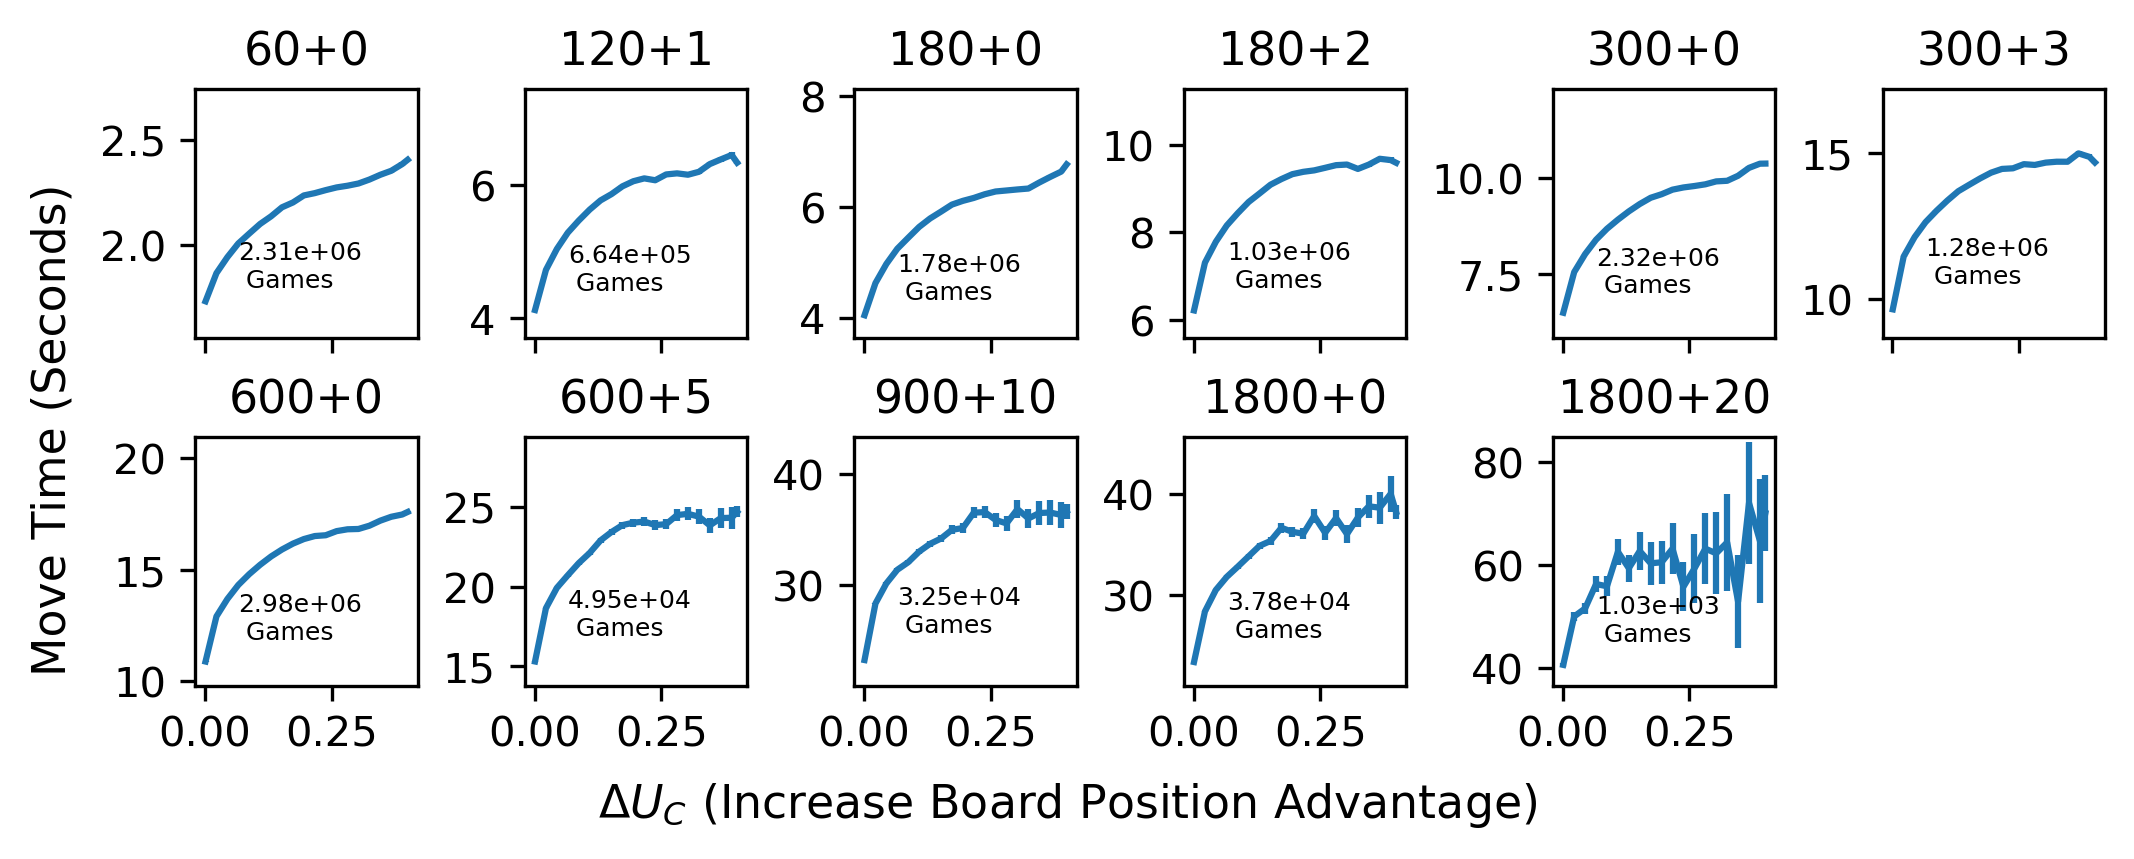

In [8]:
fig,ax = plt.subplots(2,6,constrained_layout=True,sharex=True,figsize=(7,2.75),dpi=300)
plt.rcParams['font.size'] = 8

for i in range(len(these_tcs)):
    
    row = int(np.floor(i / 6))
    col = i % 6
    
    tc_df = agg_df.loc[agg_df.time_condition == these_tcs[i]].reset_index(drop=True)
    ax[row,col].errorbar(tc_df.voc_bin, tc_df.rtmean,yerr=tc_df['sem'])
    ax[row,col].set_title(these_tcs[i], fontsize=11)
    ax[row,col].text(tc_df.voc_bin[3], np.sum(tc_df.rtmean[:2])/2, '{:0.2e}'.format(total_games[i])+'\n Games', fontsize=6)
    
    plot_bottom = tc_df.rtmean[0]*.9
    plot_top = tc_df.rtmean.iloc[-1] + (tc_df.rtmean.iloc[-1] - tc_df.rtmean[0])/2
    ax[row,col].set_ylim(plot_bottom,plot_top)
    

fig.supxlabel('$\Delta U_C$ (Increase Board Position Advantage)', fontsize=11)
fig.supylabel('Move Time (Seconds)',fontsize=11)

fig.delaxes(ax[1,5])
# plt.savefig("paper_figs/RT_data_plot.svg", format='svg', transparent=True,  bbox_inches='tight',pad_inches=0)
# plt.savefig("paper_figs/RT_data_plot.pdf", format='pdf', transparent=True,  bbox_inches='tight',pad_inches=0)


#### Place all these on the same plot to see contrast (and compare to later predictions from opportunity cost time analysis)

Text(0, 0.5, 'Mean Move Time (Seconds)')

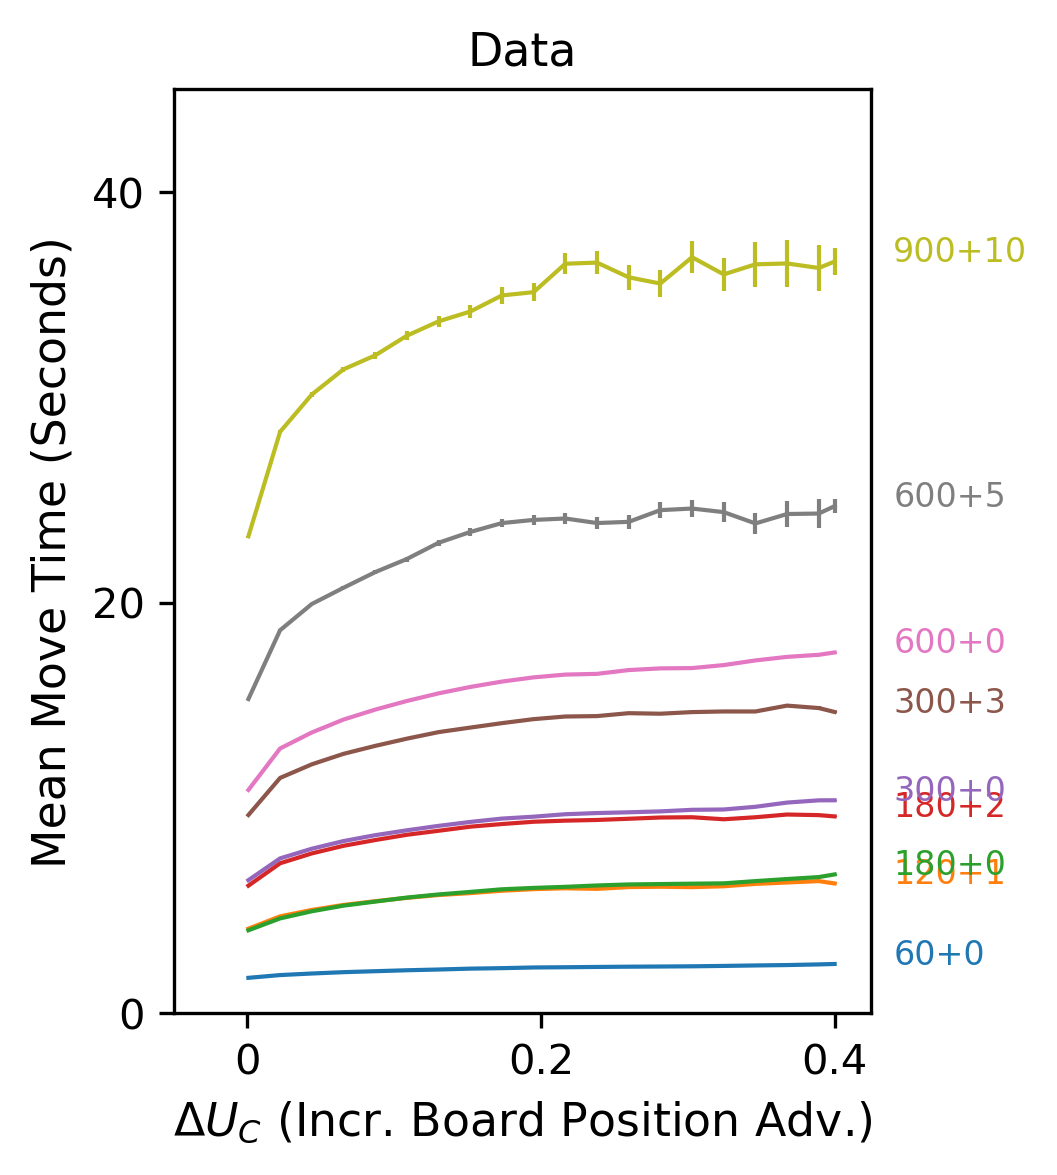

In [9]:
# plot some of these on the same plot
sub_tcs = ['60+0', '120+1', '180+0',
                '180+2', '300+0', '300+3',
                '600+0', '600+5', '900+10']

palette = sns.color_palette(None, len(sub_tcs))

text_distance = [0, 0, 0, 0, 0, 0, 0, 0, 0]

fig,ax = plt.subplots(1,figsize=(3,4),dpi=300)
for i in range(len(sub_tcs)):
    tc_df = agg_df.loc[agg_df.time_condition == sub_tcs[i]].reset_index(drop=True)
    ax.errorbar(tc_df.voc_bin, tc_df.rtmean,yerr=tc_df['sem'], color=palette[i],  lw=1)
    ax.text(tc_df.voc_bin.iloc[-1] + .04, tc_df.rtmean.iloc[-1] + 1*text_distance[i], sub_tcs[i],color=palette[i], fontsize=8)

ax.set_xticks([0, .2, .4])
ax.set_xlim(-.05,.425)
ax.set_ylim(0,45)
ax.set_xticks([0, .2, .4])
ax.set_xticklabels([0, .2, .4], fontsize=10)
ax.set_yticks([0, 20, 40])
ax.set_yticklabels([0, 20, 40], fontsize=10)
ax.set_title("Data", fontsize=11)

    
ax.set_xlabel('$\Delta U_C$ (Incr. Board Position Adv.)', fontsize=11)
ax.set_ylabel('Mean Move Time (Seconds)',fontsize=11)

#plt.savefig("paper_figs/RT_data_single_plot.svg", format='svg', transparent=True,  bbox_inches='tight',pad_inches=0)
#plt.savefig("paper_figs/RT_data_single_plot.pdf", format='pdf', transparent=True,  bbox_inches='tight',pad_inches=0)

#### Plot some mean RTs split by Elo for supplement

In [10]:
to_save_folder = os.path.join(working_folder, "aggregate_voc_vs_rt")
res_dfs=[]
i = 0
for i in range(len(these_tcs)):
    for job_idx in job_idxs:
        file_name = 'voc_vs_RT_split_elo_{}_{}'.format(these_tcs[i],job_idx)
        res_df = pd.read_csv(os.path.join(to_save_folder, file_name), index_col=0)
        res_df['time_condition']=these_tcs[i]
        res_df['job_idx']=job_idx
        res_dfs.append(res_df)
        

res_df_se = pd.concat(res_dfs,ignore_index=True)
res_df_se = res_df_se.loc[res_df_se.rtcount>0].reset_index(drop=True)

res_df_se.voc_bin[res_df_se.voc_bin>.4]=.4
agg_df_se_pe = res_df_se.groupby(['voc_bin', 'elo_bin', 'time_condition']).agg({'rtmean':'mean', 'rt_squaredmean':'mean', 'rtcount': 'sum'}).reset_index()
agg_df_se_pe['sem']=np.sqrt(agg_df_se_pe['rt_squaredmean'] - np.power(agg_df_se_pe['rtmean'],2))/np.sqrt(agg_df_se_pe['rtcount'])

Text(0.02, 0.5, 'Move Time (Seconds)')

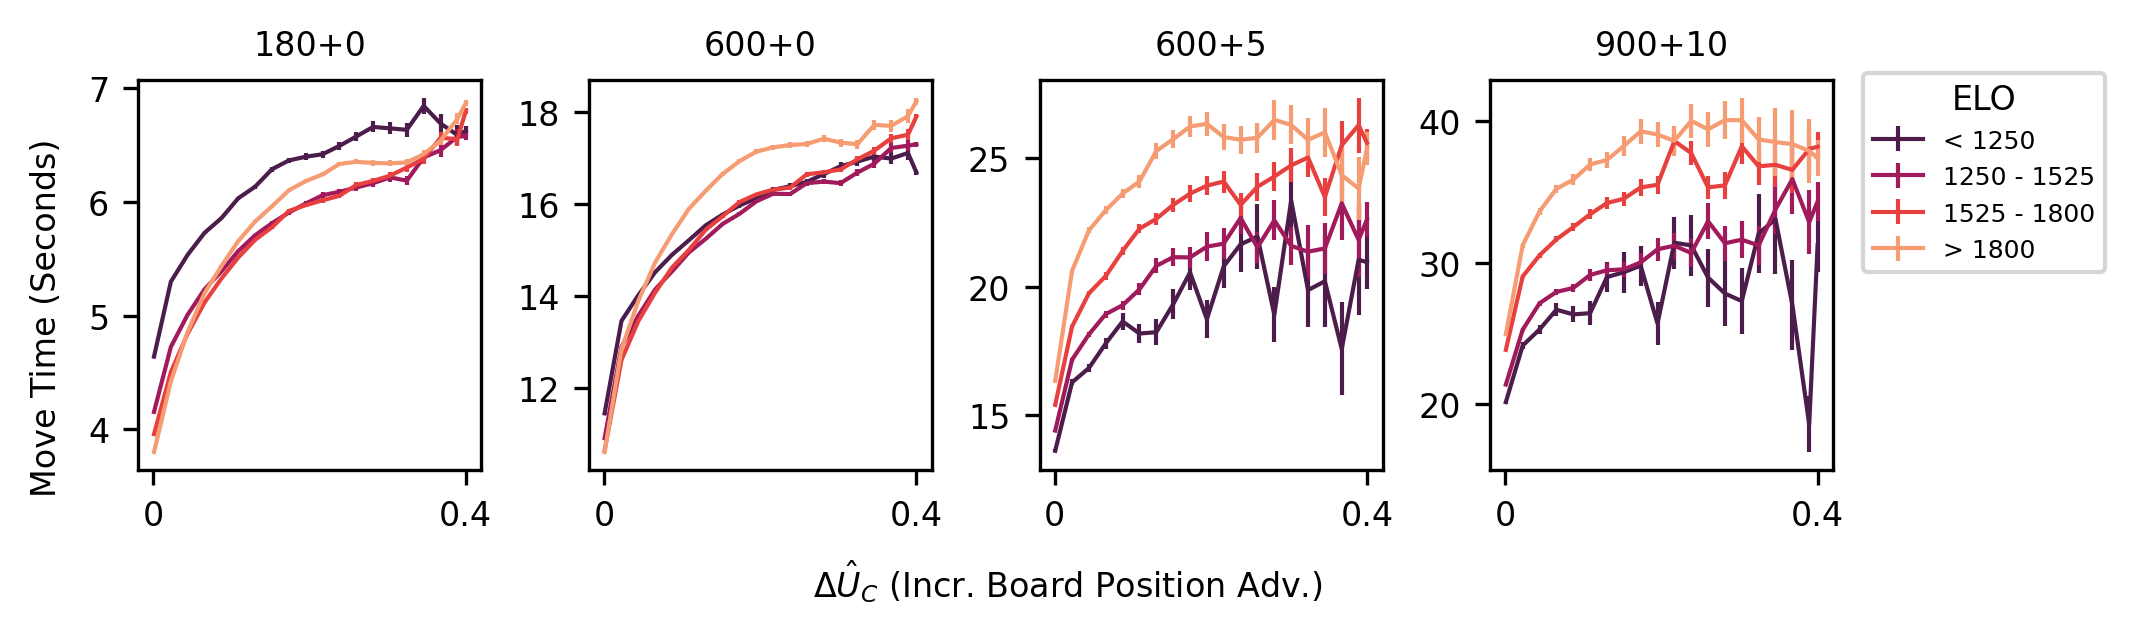

In [11]:
unique_elo_bins = agg_df_se_pe.elo_bin.unique()

sub_tcs = ['180+0', '600+0','600+5','900+10']

palette = sns.color_palette("rocket", 4)

fig,ax = plt.subplots(1,len(sub_tcs),figsize=(7,2),dpi=300,sharex=True,constrained_layout=True)

elo_line_labels = ["< 1250", "1250 - 1525", "1525 - 1800", "> 1800" ]

for i in range(len(sub_tcs)):
    tc_df = agg_df_se_pe.loc[agg_df_se_pe.time_condition == sub_tcs[i]].reset_index(drop=True)
    elo_bins = tc_df.elo_bin.unique()
    cmap = sns.light_palette("seagreen", as_cmap=True)
    
    for elo_idx,this_elo in enumerate(unique_elo_bins):
        elo_df = tc_df.loc[tc_df.elo_bin == this_elo].reset_index(drop=True)
        ax[i].errorbar(elo_df.voc_bin, elo_df.rtmean,yerr=elo_df['sem'],  lw=1, color = palette[elo_idx], alpha = 1, label = elo_line_labels[elo_idx])
    ax[i].set_xticks([0, .4])
    ax[i].set_xticklabels([0, .4], fontsize=8)

    
    ax[i].set_xlabel(None)
    ax[i].set_ylabel(None)
    ax[i].set_title(sub_tcs[i], fontsize=8)

ax[i].legend(title = "ELO", bbox_to_anchor=(1.05,1.05), prop={'size': 6})

fig.supxlabel('$\Delta \hat{U}_C$ (Incr. Board Position Adv.)', fontsize=8)
fig.supylabel('Move Time (Seconds)',fontsize=8)

#plt.savefig("paper_figs/RT_data_split_elo.svg", format='svg', transparent=True,  bbox_inches='tight',pad_inches=0)
#plt.savefig("paper_figs/RT_data_split_elo.pdf", format='pdf', transparent=True,  bbox_inches='tight',pad_inches=0)

#### Also make some plots splitting by time left for comparing with opportunity cost predictions (supplement)

In [12]:
res_dfs=[]
total_time_vals = [60, 180, 300, 600, 1800]
time_left_vals = [60, 180, 300, 600, 1800]
sub_tcs = ['60+0', '180+0', '300+0', '600+0', '1800+0']
for job_idx in range(11):
    for tc_idx in range(len(sub_tcs)):
        for tl_idx in range(len(time_left_vals)):
            if total_time_vals[tc_idx]>=time_left_vals[tl_idx]:

                file_name = 'time_left_split_{}_{}_{}'.format(sub_tcs[tc_idx],time_left_vals[tl_idx], job_idx)
                res_df=pd.read_csv(os.path.join(to_save_folder,file_name),index_col=0)
                res_df['job_idx']=job_idx
                res_df['time_left'] = time_left_vals[tl_idx]
                res_df['time_condition'] = sub_tcs[tc_idx]
                res_dfs.append(res_df)
                
res_df_tl = pd.concat(res_dfs,ignore_index=True)
res_df_tl = res_df_tl.loc[res_df_tl.rtcount>0].reset_index(drop=True)


res_df_tl.voc_bin[res_df_tl.voc_bin>.4]=.4
agg_df_tl = res_df_tl.groupby(['voc_bin', 'time_left', 'time_condition']).agg({'rtmean':'mean', 'rt_squaredmean':'mean', 'rtcount': 'sum'}).reset_index()
agg_df_tl['sem']=np.sqrt(agg_df_tl['rt_squaredmean'] - np.power(agg_df_tl['rtmean'],2))/np.sqrt(agg_df_tl['rtcount'])

Text(0.02, 0.5, 'Move Time (Seconds)')

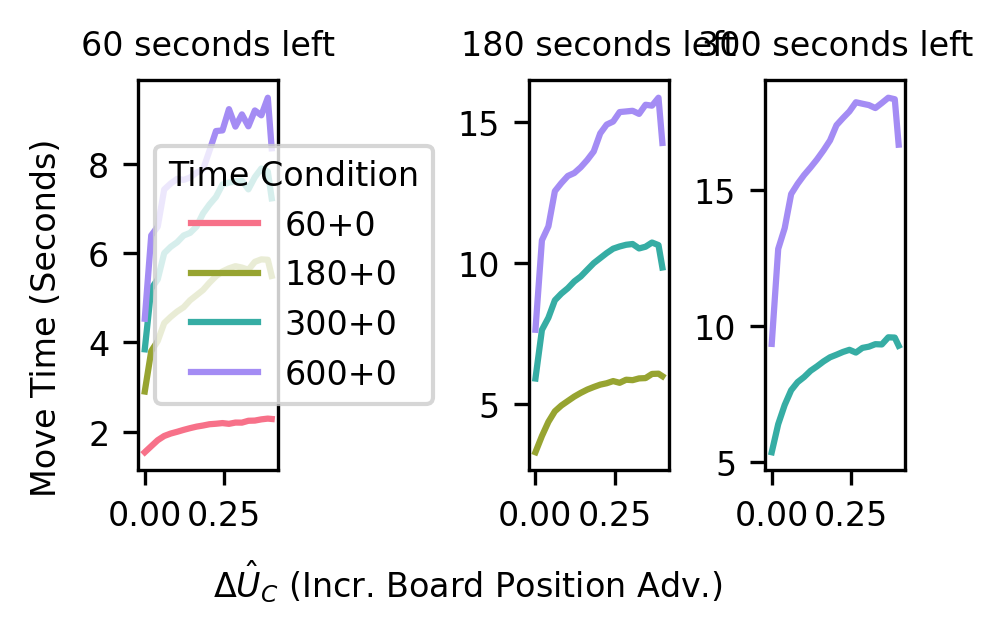

In [13]:
# do it by time-left

fig,ax = plt.subplots(1,3,figsize=(3,2),dpi=300,sharex=True,constrained_layout=True)
sub_tcs = ['60+0', '180+0', '300+0', '600+0']

palette = sns.color_palette("husl", len(sub_tcs))

# set the colors... 

for tl_idx in range(3):
    tl_df = agg_df_tl.loc[agg_df_tl.time_left == time_left_vals[tl_idx]].reset_index(drop=True)

    for tc_idx in range(len(sub_tcs)):
        if total_time_vals[tc_idx]>=time_left_vals[tl_idx]:
            tc_df = tl_df.loc[tl_df.time_condition==sub_tcs[tc_idx]].reset_index(drop=True)
            ax[tl_idx].plot(tc_df.voc_bin, tc_df.rtmean, label = sub_tcs[tc_idx], color=palette[tc_idx])
        ax[tl_idx].set_title('{} seconds left'.format(time_left_vals[tl_idx]), fontsize=8)
        
ax[0].legend(title = "Time Condition", fontsize=8)

fig.supxlabel('$\Delta \hat{U}_C$ (Incr. Board Position Adv.)', fontsize=8)
fig.supylabel('Move Time (Seconds)',fontsize=8)

#plt.savefig("paper_figs/RT_data_split_time_left.svg", format='svg', transparent=True,  bbox_inches='tight',pad_inches=0)
#plt.savefig("paper_figs/RT_data_split_time_left.pdf", format='pdf', transparent=True,  bbox_inches='tight',pad_inches=0)